### Hyperparameter definition

In [1]:
hyperparameters = {
    'subject_tokens': 'xon',
    'subject_prompt': 'a xon dog',
    'class_prompt': 'a dog',
    'num_prior_images': 1000,
    'learning_rate': 1e-06,
    'num_train_epochs': 1000,
    'prior_batch_size': 5
}

use_dreambooth_prompts = True
subject_identifier = hyperparameters['subject_tokens']
subject_prompt = hyperparameters['subject_prompt']
class_prompt = hyperparameters['class_prompt']
num_prior_images = hyperparameters['num_prior_images']
learning_rate = hyperparameters['learning_rate']
num_train_epochs = hyperparameters['num_train_epochs']
prior_batch_size = hyperparameters['prior_batch_size']

In [2]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
from datasets import load_dataset, concatenate_datasets
from transformers import CLIPTextModel, CLIPTokenizer
from PIL import Image
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset

### Data loading

In [3]:
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
text_encoder = CLIPTextModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="text_encoder")

In [4]:
# Define image transformations
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [5]:
from torch.utils.data import Dataset
import os

class CustomDataset(Dataset):
    def __init__(self, image_dir, subject_prompt, class_prompt, tokenizer, transforms, use_dreambooth_prompts=True):
        self.image_dir = image_dir
        self.subject_prompt = subject_prompt
        self.class_prompt = class_prompt
        self.tokenizer = tokenizer
        self.image_paths = [os.path.join(image_dir, img) for img in os.listdir(image_dir) if img.endswith(('.png', '.jpg', '.jpeg'))]
        self.transform = transforms
        self.use_dreambooth_prompts = use_dreambooth_prompts

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        image = self.transform(image)
        
        prompt = self.subject_prompt if self.use_dreambooth_prompts else self.class_prompt
        encoding = self.tokenizer(prompt, padding='max_length', truncation=True, max_length=self.tokenizer.model_max_length, return_tensors='pt')
        
        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()
        
        return image, input_ids, attention_mask

In [6]:
image_dir = '../data/paper_dataset/dog'
dataset = CustomDataset(image_dir, subject_prompt, class_prompt, tokenizer, train_transforms,)

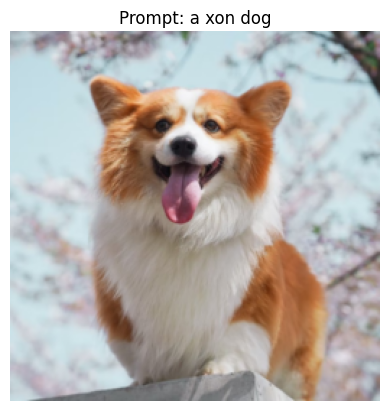

In [7]:
import matplotlib.pyplot as plt
# Function to visualize an image
def visualize_image(dataset, idx):
    image, input_ids, attention_mask = dataset[idx]
    image = image.permute(1, 2, 0)  # Change the order of dimensions for visualization
    image = image * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])  # Unnormalize the image
    image = image.numpy()
    
    plt.imshow(image)
    plt.title(f"Prompt: {dataset.subject_prompt if dataset.use_dreambooth_prompts else dataset.class_prompt}")
    plt.axis('off')
    plt.show()

# Visualize the first image in the dataset
visualize_image(dataset, 0)

In [8]:
def collate_fn(examples):
    pixel_values = torch.stack([example[0] for example in examples])
    pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()
    input_ids = torch.stack([example[1] for example in examples])
    attention_mask = torch.stack([example[2] for example in examples])
    return {"pixel_values": pixel_values, "input_ids": input_ids, "attention_mask": attention_mask}

In [9]:
train_batch_size = 5
train_dataloader = DataLoader(
    dataset,
    shuffle=True,
    collate_fn=collate_fn,
    batch_size=train_batch_size,
)

### Load the diffusion model for tuning

In [10]:
from diffusers import AutoencoderKL, DDPMScheduler, UNet2DConditionModel, StableDiffusionPipeline
from diffusers.optimization import get_scheduler

In [11]:
pretrained_model_name_or_path = "CompVis/stable-diffusion-v1-4"
revision = None
variant = None

In [12]:
noise_scheduler = DDPMScheduler.from_pretrained(pretrained_model_name_or_path, subfolder="scheduler")
vae = AutoencoderKL.from_pretrained(pretrained_model_name_or_path, subfolder="vae", revision=revision, variant=variant)
unet = UNet2DConditionModel.from_pretrained(pretrained_model_name_or_path, subfolder="unet", revision=revision, variant=variant)

In [13]:
import torch
import subprocess

def get_free_gpu():
    result = subprocess.check_output(
        ['nvidia-smi', '--query-gpu=memory.free', '--format=csv,nounits,noheader']
    )
    free_memory = [int(x) for x in result.decode('utf-8').strip().split('\n')]
    return free_memory.index(max(free_memory))

if torch.cuda.is_available() and torch.cuda.device_count() > 1:
    free_gpu = get_free_gpu()
    device = torch.device(f"cuda:{free_gpu}")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

weight_dtype = torch.float32

unet.to(device, dtype=weight_dtype)
vae.to(device, dtype=weight_dtype)
text_encoder.to(device, dtype=weight_dtype)

CLIPTextModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 768)
      (position_embedding): Embedding(77, 768)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), ep

### Set Up Prior Preservation Mechanism

In [14]:
use_prior_preservation = True
prior_loss_weight = 1.0  # lambda in the paper

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Generating prior preservation latents...
Generating images 0 to 63


  0%|          | 0/50 [00:00<?, ?it/s]

Generating images 64 to 127


  0%|          | 0/50 [00:00<?, ?it/s]

Generating images 128 to 191


  0%|          | 0/50 [00:00<?, ?it/s]

Generating images 192 to 255


  0%|          | 0/50 [00:00<?, ?it/s]

Generating images 256 to 319


  0%|          | 0/50 [00:00<?, ?it/s]

Generating images 320 to 383


  0%|          | 0/50 [00:00<?, ?it/s]

Generating images 384 to 447


  0%|          | 0/50 [00:00<?, ?it/s]

Generating images 448 to 511


  0%|          | 0/50 [00:00<?, ?it/s]

Generating images 512 to 575


  0%|          | 0/50 [00:00<?, ?it/s]

Generating images 576 to 639


  0%|          | 0/50 [00:00<?, ?it/s]

Generating images 640 to 703


  0%|          | 0/50 [00:00<?, ?it/s]

Generating images 704 to 767


  0%|          | 0/50 [00:00<?, ?it/s]

Generating images 768 to 831


  0%|          | 0/50 [00:00<?, ?it/s]

Generating images 832 to 895


  0%|          | 0/50 [00:00<?, ?it/s]

Generating images 896 to 959


  0%|          | 0/50 [00:00<?, ?it/s]

Generating images 960 to 1023


  0%|          | 0/50 [00:00<?, ?it/s]

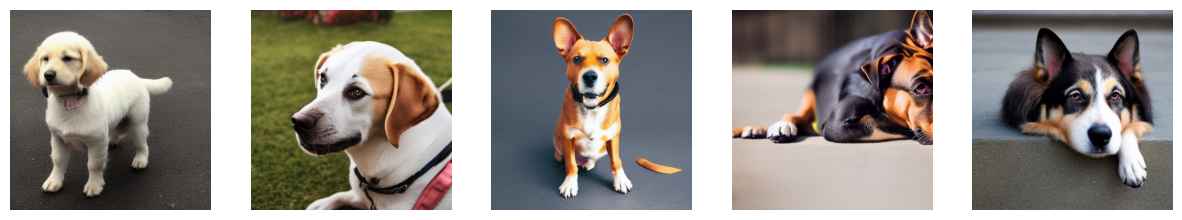

In [ ]:
import matplotlib.pyplot as plt
import torch

if use_prior_preservation:
    
    # Create a frozen copy of the original UNet for generating prior samples.
    unet_pretrained = UNet2DConditionModel.from_pretrained(pretrained_model_name_or_path, 
                                                           subfolder="unet", revision=revision, variant=variant)
    unet_pretrained.to(device, dtype=weight_dtype)
    unet_pretrained.eval()
    
    # Build a separate pipeline using the frozen UNet.
    pipeline_pretrained = StableDiffusionPipeline(
        vae=vae,
        text_encoder=text_encoder,
        tokenizer=tokenizer,
        unet=unet_pretrained,
        scheduler=noise_scheduler,
        safety_checker=None,
        feature_extractor=None,
    ).to(device)
    
    # Pre-generate a small set of prior samples.
    num_prior_images = num_prior_images
    batch_size = 64
    prior_latents_list = []
    generated_images = []
    print("Generating prior preservation latents...")
    
    for i in range(0, num_prior_images, batch_size):
        print(f"Generating images {i} to {i + batch_size - 1}")
        with torch.no_grad(), torch.autocast("cuda"):
            output = pipeline_pretrained([class_prompt] * batch_size, num_inference_steps=50, guidance_scale=7.5)
        
        for j in range(batch_size):
            gen_image = output.images[j].convert("RGB")
            
            if i + j < 5:
                generated_images.append(gen_image)
            
            # Convert generated image to tensor.
            gen_image_tensor = train_transforms(gen_image).unsqueeze(0).to(device, dtype=weight_dtype)
            with torch.no_grad():
                latent = vae.encode(gen_image_tensor).latent_dist.sample() * vae.config.scaling_factor
            prior_latents_list.append(latent)
    
    # Prepare prior prompt embeddings 
    prior_inputs = tokenizer(class_prompt, return_tensors="pt", max_length=tokenizer.model_max_length,
                             padding="max_length", truncation=True)
    prior_input_ids = prior_inputs["input_ids"].to(device)
    prior_attention_mask = prior_inputs["attention_mask"].to(device)
    with torch.no_grad():
        prior_embeddings = text_encoder(input_ids=prior_input_ids, attention_mask=prior_attention_mask).last_hidden_state

    # Visualize the first five generated images
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    for idx, img in enumerate(generated_images):
        axes[idx].imshow(img)
        axes[idx].axis('off')
    plt.show()

In [16]:
import torch
prior_latents_tensor = torch.cat(prior_latents_list, dim=0)
torch.save(prior_latents_tensor, '../data/prior_imgs/dog/prior_latents_tensor.pt')
torch.save(prior_embeddings, '../data/prior_imgs/prior_embeddings.pt')

### Set Up Training Hyperparameters & Optimizer

In [17]:
optimizer = torch.optim.AdamW(
    list(unet.parameters()) + list(vae.parameters()) + list(text_encoder.parameters()),
    lr=learning_rate,
    betas=(0.9, 0.999),
    weight_decay=1e-2,
    eps=1e-08,
)

In [18]:
# Use total steps based on dataset size (using custom_dataset length)
num_training_steps = num_train_epochs * len(dataset) // train_batch_size
lr_scheduler = get_scheduler(
    "constant",
    optimizer=optimizer,
    num_warmup_steps=500,
    num_training_steps=num_training_steps,
)

### Set up the prior_dataloader

In [ ]:
# Load the tensor from the file
prior_latents_tensor = torch.load('../data/prior_imgs/dog/prior_latents_tensor.pt')
prior_embeddings = torch.load('../data/prior_imgs/dog/prior_embeddings.pt')

In [20]:
prior_dataset = TensorDataset(prior_latents_tensor)
prior_dataloader = DataLoader(prior_dataset, batch_size=prior_batch_size, shuffle=True)

### Model tuning

In [21]:
# Training Loop with Dual (Subject + Prior) Losses
for epoch in tqdm(range(num_train_epochs), desc="Epochs"):
    unet.train()
    epoch_losses = []

    prior_iter = iter(prior_dataloader)

    for index, batch in enumerate(tqdm(train_dataloader, desc="Batches", leave=False)):
        # Move subject batch to device.
        pixel_values = batch["pixel_values"].to(dtype=weight_dtype, device=device)
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)

        # Convert subject images to latent space.
        latents = vae.encode(pixel_values).latent_dist.sample() * vae.config.scaling_factor

        # Sample noise and timesteps for subject images.
        noise = torch.randn_like(latents, device=device)
        timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, 
                                  (latents.shape[0],), device=device).long()
        noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

        # Get text embeddings from subject prompts.
        outputs = text_encoder(input_ids=input_ids, attention_mask=attention_mask)
        embeddings = outputs.last_hidden_state

        # Predict noise residual for subject branch.
        model_pred = unet(noisy_latents, timesteps, encoder_hidden_states=embeddings,
                          encoder_attention_mask=attention_mask, return_dict=False)[0]
        loss_subject = F.mse_loss(model_pred.float(), noise.float(), reduction="mean")

        # ----- Prior Preservation Loss -----
        if use_prior_preservation:
            
            try:
                prior_batch = next(prior_iter)[0].to(device)
            except StopIteration:
                prior_iter = iter(prior_dataloader)
                prior_batch = next(prior_iter)[0].to(device)


            # For the prior branch, sample noise and timesteps.
            noise_prior = torch.randn_like(prior_batch, device=device)
            t_prior = torch.randint(0, noise_scheduler.config.num_train_timesteps, 
                                      (prior_batch.shape[0],), device=device).long()
            noisy_prior_latents = noise_scheduler.add_noise(prior_batch, noise_prior, t_prior)

            # Expand prior embeddings to match batch size.
            prior_embeddings_expanded = prior_embeddings.expand(noisy_prior_latents.shape[0], -1, -1)
            prior_attention_mask_expanded = prior_attention_mask.expand(noisy_prior_latents.shape[0], -1)

            # Predict noise residual for prior branch.
            model_pred_prior = unet(noisy_prior_latents, t_prior, encoder_hidden_states=prior_embeddings_expanded,
                                    encoder_attention_mask=prior_attention_mask_expanded, return_dict=False)[0]
            loss_prior = F.mse_loss(model_pred_prior.float(), noise_prior.float(), reduction="mean")
        else:
            loss_prior = 0.0

        # Total loss is the sum of subject loss and weighted prior loss.
        loss = loss_subject + prior_loss_weight * loss_prior

        optimizer.zero_grad()  
        loss.backward()  
        optimizer.step()  
        lr_scheduler.step() 

        epoch_losses.append(loss.item())

    avg_loss = sum(epoch_losses) / len(epoch_losses)
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch + 1}/{num_train_epochs}, Loss: {avg_loss:.4f}")

Epochs:   0%|          | 1/1000 [00:00<09:59,  1.67it/s]

Epoch 1/1000, Loss: 0.4200


Epochs:  10%|█         | 101/1000 [00:50<07:23,  2.03it/s]

Epoch 101/1000, Loss: 0.1944


Epochs:  20%|██        | 201/1000 [01:39<06:33,  2.03it/s]

Epoch 201/1000, Loss: 0.4315


Epochs:  30%|███       | 301/1000 [02:29<05:44,  2.03it/s]

Epoch 301/1000, Loss: 0.2582


Epochs:  40%|████      | 401/1000 [03:18<04:53,  2.04it/s]

Epoch 401/1000, Loss: 0.3762


Epochs:  50%|█████     | 501/1000 [04:08<04:05,  2.03it/s]

Epoch 501/1000, Loss: 0.1284


Epochs:  60%|██████    | 601/1000 [04:57<03:16,  2.03it/s]

Epoch 601/1000, Loss: 0.1222


Epochs:  70%|███████   | 701/1000 [05:46<02:26,  2.05it/s]

Epoch 701/1000, Loss: 0.2798


Epochs:  80%|████████  | 801/1000 [06:35<01:39,  2.00it/s]

Epoch 801/1000, Loss: 0.1464


Epochs:  90%|█████████ | 901/1000 [07:25<00:48,  2.03it/s]

Epoch 901/1000, Loss: 0.2968


Epochs: 100%|██████████| 1000/1000 [08:14<00:00,  2.02it/s]


### Inference: Generate Images using the Fine-Tuned Model

In [22]:
from diffusers import StableDiffusionPipeline

pipeline = StableDiffusionPipeline(
    vae=vae,
    text_encoder=text_encoder,
    tokenizer=tokenizer,
    unet=unet,
    scheduler=noise_scheduler,
    safety_checker=None,
    feature_extractor=None,
)
pipeline = pipeline.to(device)

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


### Check only the subject_prompt without additional stylization

  0%|          | 0/500 [00:00<?, ?it/s]

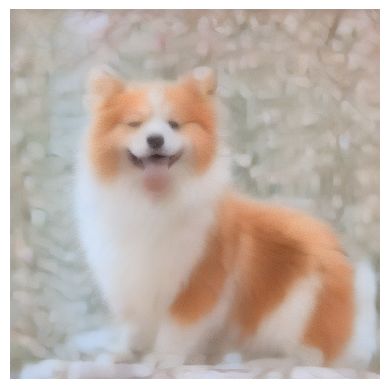

In [96]:
prompt = subject_prompt
with torch.autocast(device.type):
    images = pipeline(prompt, num_inference_steps=500, guidance_scale=7.5).images

for idx, img in enumerate(images):
    plt.imshow(img)
    plt.axis("off")
    plt.show()
    img.save(f"target_generated_image_{idx}.png")

### Check the subject_prompt with additional stylization

In [52]:
prompt = subject_prompt + " in beautifyl landscape with river, forest and mountines"

  0%|          | 0/100 [00:00<?, ?it/s]

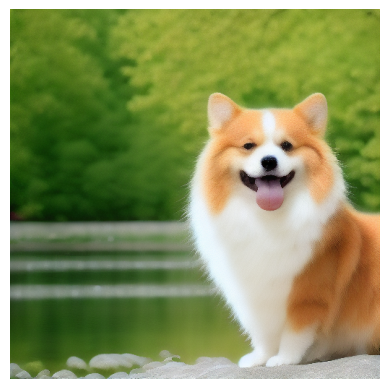

In [53]:
with torch.autocast(device.type):
    images = pipeline(prompt, num_inference_steps=100, guidance_scale=7.5).images

for idx, img in enumerate(images):
    plt.imshow(img)
    plt.axis("off")
    plt.show()
    img.save(f"styled_generated_image_{idx}.png")


In [94]:
prompt = subject_prompt + " in astronaut costume against moon and stars. The xon dog stands proudly on the rocky lunar surface, with its paw slightly raised as if exploring."

  0%|          | 0/100 [00:00<?, ?it/s]

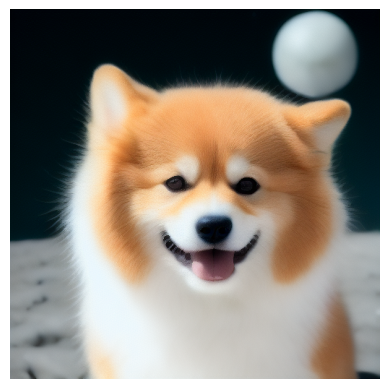

In [95]:
with torch.autocast(device.type):
    images = pipeline(prompt, num_inference_steps=100, guidance_scale=7.5).images

for idx, img in enumerate(images):
    plt.imshow(img)
    plt.axis("off")
    plt.show()
    img.save(f"styled_generated_image_{idx}.png")
